### 使用 piecewise Rossler 模型模拟爆炸同步现象
ref: I. Leyva, et al. Explosive first-order transition to synchrony in networked chaotic oscillators, Phys. Rev. Lett. 108, 168702 (2012).

model: piecewise Rossler model

network: scale-free network

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import networkx as nx
from scipy.sparse import coo_matrix
from joblib import Parallel, delayed

In [27]:
seed = 0
random.seed(seed)
np.random.seed(seed)

In [28]:
# 演算法
@njit
def RK4(fun, x0, t, dt, *args):
    """
    使用 Runge-Kutta 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return:
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    k1 = fun(x0, t, *args)
    k2 = fun(x0 + (dt / 2.) * k1, t + (dt / 2.), *args)
    k3 = fun(x0 + (dt / 2.) * k2, t + (dt / 2.), *args)
    k4 = fun(x0 + dt * k3, t + dt, *args)

    x0 += (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

    return x0

# piecewise Rossler model
@njit
def piecewise_Rossler(vars, t, I, alpha, beta, R, mu, gamma):
    res = np.zeros_like(vars)
    # 状态变量
    x, y, z = vars

    # g_x = np.zeros_like(x) if x <= 3. else mu*(x - 3.)
    g_x = np.where(x <= 3., 0., mu*(x - 3.))
    
    dx_dt = gamma * (-alpha*(x - I) - z - beta*y)
    dy_dt = gamma * (x - (0.02 - 10/R)*y)
    dz_dt = gamma * (g_x - z)

    res[0] = dx_dt
    res[1] = dy_dt
    res[2] = dz_dt

    return res

In [29]:
# 耦合函数
@njit
def coupling_func(vars, weight, pre_ids, post_ids):
    currents = weight * (vars[pre_ids] - vars[post_ids])

    # 节点数量
    num_nodes = len(vars)  # 耦合后节点总数

    Icoup = np.bincount(post_ids, weights=currents, minlength=num_nodes)

    return Icoup

In [30]:
@njit
def net(N, A_adj, weight_list):
    # ============ 设置节点参数 ============ 
    alpha = 0.05
    beta = 0.5
    R = 100                 # chaos(R: 55-110)
    mu = 15
    gamma_base = 10000  

    # 状态变量初始化
    x0 = 0.1*np.ones(N)
    y0 = 0.2*np.ones(N)
    z0 = 0.3*np.ones(N)
    vars_nodes = np.vstack((x0, y0, z0))        # 状态变量矩阵
    N_vars = 3          # 变量的数量

    # ============ 突触参数 ============
    post_ids, pre_ids = np.nonzero(A_adj)
    degrees = A_adj.sum(axis=1)
    dgamma = 0.2
    gamma = gamma_base * (1 + dgamma * (degrees-1) / N)     # 用来设置频率

    dt=0.0001
    # ============ 运行部分 ============
    t = 0

    # 初始化节点
    for _ in range(1_0000):
        Icoup = np.zeros(N)
        RK4(piecewise_Rossler, vars_nodes, t, dt, Icoup, alpha, beta, R, mu, gamma)

    S_list = []
    for weight in weight_list:

        # 初始网络
        for _ in range(1_0000):
            Icoup = coupling_func(vars_nodes[0], weight, pre_ids, post_ids)
            RK4(piecewise_Rossler, vars_nodes, t, dt, Icoup, alpha, beta, R, mu, gamma)

        # mem = []
        cal_n = 10_0000
        S = 0. # 同步因子
        for _ in range(cal_n):
            Icoup = coupling_func(vars_nodes[0], weight, pre_ids, post_ids)
            RK4(piecewise_Rossler, vars_nodes, t, dt, Icoup, alpha, beta, R, mu, gamma)

            # 计算同步
            phi_t =  np.arctan2(vars_nodes[1], vars_nodes[0]) 
            S += np.abs(np.sum(np.exp(1j * phi_t)) / N) / cal_n

            t += dt
            # mem.append(vars_nodes[0].copy())

        # return mem, S

        S_list.append(S)
    return S_list

In [31]:
# 创建无标度网络
N = 1000    # 节点数
k = 6       # 平均度
G_init = nx.complete_graph(k+1)
G = nx.barabasi_albert_graph(N, int(k/2), initial_graph=G_init)
A_adj = nx.to_numpy_array(G)
# weight = 10e-3

In [32]:
weight_list1 = np.arange(3e-4, 14.3e-3, 3e-4)
weight_list2 = np.arange(14.3e-3, 3e-4, -3e-4)
# weight_list1 = np.linspace(0., 14.3e-3, 2)
# weight_list2 = np.linspace(14.3e-3, 0, 2)
weight_list = [weight_list1, weight_list2]

In [33]:
@njit(parallel=True)
def Parallel_net(N, A_adj, weight_list):
    len = weight_list[0].shape[0]
    results = np.zeros((2, len))
    for i in prange(2):
        result = net(N, A_adj, weight_list[i])
        results[i] = np.asarray(result)
        
    return results

In [34]:
results = Parallel_net(N, A_adj, weight_list)

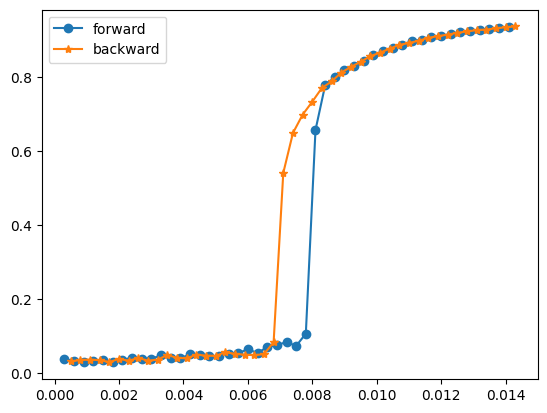

In [35]:
plt.plot(weight_list1, results[0], 'o-', label='forward')
plt.plot(weight_list2, results[1], '*-', label='backward')
plt.legend()
plt.show()

In [36]:
# mem, S = net(N, A_adj, weight)
# mem = np.asarray(mem)
# plt.plot(mem)
# plt.xlim(0, 1_00)
# plt.show()